In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import re
import seaborn as sns
import docx
import pylab
pd.set_option('display.max_rows', None)
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import scipy
import unicodeit

In [2]:
%matplotlib inline

In [3]:
#Define cell parameters
cell_dm_bohr = 19.3217899560
cell_dm_ang = cell_dm_bohr * 0.529177
cell_matrix = np.array([1.00000000000,  0.000000000000,  0.00000000000,
                          -0.500000000000,  0.866025403784,  0.000000000000, 
                          0.000000000000,  0.000000000000,  2.283539330750]).reshape(3,3)
cell_matrix = cell_matrix * cell_dm_ang

In [4]:
def qsline_to_coordinate(coord_line, cell_matrix):
    coord_list = coord_line.split()[1:4]
    atom_type = coord_line.split()[0]
    for n in range(len(coord_list)):
        coord_list[n] = re.sub("d","0",coord_list[n])
        coord_list[n] = float(coord_list[n])
    coord_array = np.array(coord_list).reshape(1,3)
    coord_array_ang = np.dot(coord_array,cell_matrix)
    return (atom_type,coord_array_ang)

main_dir = './'
materials = ['0_CuNi','1_Ag_subCu','2_Au_subCu','6_Pd_subNi','7_Pt_subNi','9_Fe_subNi', '11_Pd_subCu','13_Ag_subNi','14_Au_subNi']
#materials = ['14_Au_subNi']
molecules = ['N2_main']
mol = 'N2_main'
n_sites = 19
N2_E = -40.27971791 


for material in materials:
    df = pd.DataFrame()
    surf_folder = main_dir + material + '/' + '1_opt_relax/'
    surf_output = open(surf_folder + 'output.out','r')
    surf_outlines = surf_output.readlines()
    for n_line in range(len(surf_outlines)):
        if 'total energy              =' in surf_outlines[n_line]:
            surf_E = float(surf_outlines[n_line].split()[-2])
    #print('surf_E is: ', surf_E)
    ad_Es = []
    NN_distances = []
    site_names = []
    N1M_dist = []
    N2M_dist = []
    NM_min_list = [] #This shows the min of N1M and N2M
    NM_max_list = []
    system_names = []
    ad_sites_dir_1 = main_dir + material + '/' + str(molecules.index(mol)) + '_' + mol + '/1_ad_sites_1_10/'
    ad_sites_dir_2 = main_dir + material + '/' + str(molecules.index(mol)) + '_' + mol + '/2_ad_sites_11_19/'
    for i in range(1,n_sites + 1):
        if i < 11:
            ad_site_file = open(ad_sites_dir_1 + f'ad_site_{i}.out','r')
        else:
            ad_site_file = open(ad_sites_dir_2 + f'ad_site_{i}.out','r')
        adsite_lines = ad_site_file.readlines()
        for n_line in range(len(adsite_lines)):
            if 'Begin final coordinates' in adsite_lines[n_line]:
                n_start_coord = n_line
            if 'total energy              =' in adsite_lines[n_line]:
                adsite_E = float(adsite_lines[n_line].split()[-2])
            if 'End final coordinates' in adsite_lines[n_line]:
                n_end_coord = n_line            
        #Finding the N-N distance
        N1_coord_line = adsite_lines[n_end_coord-2]
        N2_coord_line = adsite_lines[n_end_coord-1]    
        N1_coord_ang = qsline_to_coordinate(N1_coord_line,cell_matrix)[1]
        N2_coord_ang = qsline_to_coordinate(N2_coord_line,cell_matrix)[1]
        NN_dist = round(np.linalg.norm(N1_coord_ang - N2_coord_ang),3)
        #print(N1_coord_ang, N2_coord_ang)
        #print(NN_dist)
        
        all_atoms_N1M_dist = []
        all_atoms_N2M_dist = []
        #Calculating the distance of each atom from N1 and N2
        coordinate = adsite_lines[n_start_coord + 3: n_end_coord-2]
        for each_coord in coordinate:
            atom_coord_ang = qsline_to_coordinate(each_coord, cell_matrix)[1]
            N1_metal_dist = np.linalg.norm(N1_coord_ang - atom_coord_ang)
            N2_metal_dist = np.linalg.norm(N2_coord_ang - atom_coord_ang)
            all_atoms_N1M_dist.append(N1_metal_dist)
            all_atoms_N2M_dist.append(N2_metal_dist)
        #print(all_atoms_N1M_dist)
        #print(all_atoms_N2M_dist)
        min_N1M_dist = round(min(all_atoms_N1M_dist),4)    
        min_N2M_dist = round(min(all_atoms_N2M_dist),4)
        N_M = min([min_N1M_dist,min_N2M_dist]) 
        N_M_max = max([min_N1M_dist,min_N2M_dist]) 
        #Calculating the adsoorption energy
        adsorption_E = round((adsite_E - (N2_E + surf_E))*13.605703976,4) #eV
        #print(adsorption_E)
        ad_Es.append(adsorption_E) 
        NN_distances.append(NN_dist)
        site_names.append(f'ad_site_{i}')
        N1M_dist.append(min_N1M_dist)
        N2M_dist.append(min_N2M_dist)
        NM_min_list.append(N_M)
        NM_max_list.append(N_M_max)
        system_names.append(material)
    df["system"] = system_names
    df['site_number'] = site_names
    df['adsorption_energy (eV)-N2'] = ad_Es
    df['NN_distance (ang)-N2'] = NN_distances
    df['N1_metal_min_dist (ang)-N2'] = N1M_dist
    df['N2_metal_min_dist (ang)-N2'] = N2M_dist
    df['min mol_M distance-N2'] = NM_min_list
    df['max mol_M distance-N2'] = NM_max_list
    df.to_csv(main_dir + material + '/' + str(molecules.index(mol)) + '_' + mol + '/raw_data.csv',index=False)


    
        
        

        
        
        
        
            
            
        
    
    
    


In [5]:
def mol_orient(dissociated, adsorbed, max_nm_dist):
    if dissociated == 1:
        return None
    elif dissociated == 0 and adsorbed  == 1:
        if max_nm_dist > 2.85:
            return int(1) #vertical mol
        else:
            return int(0) #horizontal mol

In [6]:
Au_Cu_df = pd.read_csv('./2_Au_subCu/raw_data.csv')
CuNi_df = pd.read_csv('./0_CuNi/raw_data.csv')
Fe_Ni_df = pd.read_csv('./9_Fe_subNi/raw_data.csv')
Pd_Ni_df = pd.read_csv('./6_Pd_subNi/raw_data.csv')
Pt_Ni_df = pd.read_csv('./7_Pt_subNi/raw_data.csv')
Ag_Cu_df = pd.read_csv('./1_Ag_subCu/raw_data.csv')
Pd_Cu_df = pd.read_csv('./11_Pd_subCu/raw_data.csv')
Ag_Ni_df = pd.read_csv('./13_Ag_subNi/raw_data.csv')
Au_Ni_df = pd.read_csv('./14_Au_subNi/raw_data.csv')

In [7]:
#None: not adsorbed 'broken', 

ads_condition_dict = {}
ads_condition_dict['0_CuNi'] = [
                 (1,'Ni-Ni','br'), #1 
                 (2,'Ni','top'),  #2 s1
                 (3,'Ni-Ni','br'),  #3
                 (4,'Cu','top'),  #4 s4
                 (5,'Ni-Ni','br'),#5
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni','br'),  #7
                 (8,'Ni','top'),  #8 s7
                 (9,'Ni','top'),  #9 s5
                 (10,'Ni','top'),  #10 s5
                 (11,'Cu-Ni-Ni-Ni','br'),  #11
                 (12,'Ni-Ni','br'),  #12
                 (13,'Ni-Ni','br'),  #13
                 (14,'Ni-Ni-Ni','hollow'),  #14
                 (15,'Ni-Ni','br'),  #15
                 (16,'Ni-Ni','br'),  #16
                 (17,'Ni','top'),  #17 s3
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni-Ni','br')]

ads_condition_dict['1_Ag_subCu'] = [
                 (1,'Ni','top'), #1 s11
                 (2,'Ni','top'),  #2 s1
                 (3,'Ni-Ni','br'),  #3
                 (4,None,None),  #4
                 (5,'Ni-Ni','br'),  #5
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni','br'),  #7
                 (8,'Ni-Ni','br'),  #8
                 (9,'Ni','top'),  #9 s3
                 (10,'Ni','top'),  #10 s5
                 (11,'Ni-Ni','br'),  #11
                 (12,'Ni-Ni','br'),  #12
                 (13,'broken',None),  #13
                 (14,'Ni-Ni','br'),  #14
                 (15,'Ni-Ni','br'),  #15
                 (16,'Ni-Ni','br'),  #16
                 (17,None,None),  #17
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni-Ni','br')]  #19

ads_condition_dict['2_Au_subCu'] = [
                 (1,'Ni','top'), #1 s11
                 (2,'Ni','top'),  #2 s1
                 (3,'Ni-Ni','br'),  #3
                 (4,None,None),  #4
                 (5,'Ni','top'),  #5  s5
                 (6,'Ni','top'),  #6  s6
                 (7,'Ni','top'),  #7 s7
                 (8,'Ni','top'),  #8 s7
                 (9,'Ni','top'),  #9 s3
                 (10,'Ni','top'),  #10 s5
                 (11,'Ni-Ni','br'),  #11
                 (12,'Ni','top'),  #12 s5
                 (13,'broken',None),  #13
                 (14,'Ni-Ni-Ni','hollow'),  #14
                 (15,'Ni-Ni-Ni','hollow'),  #15
                 (16,'Ni','top'),  #16 s7
                 (17,'Ni','top'),  #17 s3
                 (18,'Ni','top'),  #18 s7
                 (19,'Ni-Ni-Ni','hollow')]  #19 

ads_condition_dict['6_Pd_subNi'] = [
                 (1,'Ni-Ni','br'), #1
                 (2,'Ni','top'),  #2 s1
                 (3,'Ni','top'),  #3 s3
                 (4,'Ni','top'),  #4 s3
                 (5,'Ni','top'),  #5 s3
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni','br'),  #7
                 (8,'Ni','top'),  #8  s7
                 (9,'Ni','top'),  #9 s3
                 (10,'Ni','top'),  #10 s3
                 (11,'Ni','top'),  #11 s7
                 (12,'Ni','top'),  #12 s7
                 (13,'Ni','top'),  #13 s7
                 (14,'Ni-Ni','br'),  #14
                 (15,'Ni','top'),  #15 s7
                 (16,'Ni','top'),  #16 s7
                 (17,None,None),  #17
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni','top')]  #19 s7

ads_condition_dict['7_Pt_subNi'] = [
                 (1,'Ni','top'), #1 s3
                 (2,'Ni','top'),  #2 s1
                 (3,'Ni','top'),  #3 s3
                 (4,'Ni','top'),  #4 s3
                 (5,'Ni','top'),  #5 s3
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni','br'),  #7
                 (8,'Ni','top'),  #8 s7
                 (9,'Ni','top'),  #9 s3
                 (10,'Ni','top'),  #10 s3
                 (11,'Ni','top'),  #11 s3
                 (12,'Ni','top'),  #12 s6
                 (13,'Ni-Ni','br'),  #13 
                 (14,'Ni-Ni','br'),  #14
                 (15,'Ni-Ni','br'),  #15
                 (16,'Ni-Ni','br'),  #16
                 (17,None,None),  #17
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni','top')]  #19 s6

ads_condition_dict['9_Fe_subNi'] = [
                 (1,'Ni-Ni','br'), #1
                 (2,'Ni','top'),  #2
                 (3,'Fe-Ni','br'),  #3
                 (4,'Ni','top'),  #4 s6
                 (5,'Cu-Fe-Ni-Ni','br'),  #5
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni','br'),  #7
                 (8,'Ni','top'),  #8  s7
                 (9,'Ni','top'),  #9 s3
                 (10,'Ni','top'),  #10  s5
                 (11,'Cu-Fe','br'),  #11
                 (12,'Ni','top'),  #12 s6
                 (13,'Ni-Ni','br'),  #13
                 (14,'Ni-Ni-Ni','hollow'),  #14
                 (15,'Ni','top'),  #15 s6
                 (16,'Ni-Ni','br'),  #16
                 (17,'Ni','top'),  #17 s3
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni','top')]  #19 s6

ads_condition_dict['11_Pd_subCu'] = [
                 (1,'Ni','top'), #1 s11
                 (2,'Ni','top'),  #2 s1
                 (3,'Ni-Ni','br'),  #3
                 (4,'Pd','top'),  #4 s4
                 (5,'Ni-Ni','br'),  #5
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni','br'),  #7
                 (8,'Ni-Ni','br'),  #8
                 (9,'Ni-Ni-Ni','hollow'),  #9
                 (10,'Ni','top'),  #10 s5
                 (11,'Ni-Ni','br'),  #11
                 (12,'Ni-Ni-Ni','hollow'),  #12
                 (13,'broken',None),  #13
                 (14,'Ni-Ni-Ni','hollow'),  #14
                 (15,'Ni-Ni','br'),  #15
                 (16,'Ni-Ni','br'),  #16
                 (17,'Ni','top'),  #17 s3
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni-Ni','br')]  #19

ads_condition_dict['13_Ag_subNi'] = [
                 (1,'Ni-Ni','br'), #1
                 (2,'Ni','top'),  #2 s2
                 (3,'Ni','top'),  #3 s3
                 (4,'Ni','top'),  #4 s3
                 (5,'Ni','top'),  #5 s3
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni-Ni','hollow'),  #7
                 (8,'Ni','top'),  #8 s7
                 (9,'Ni','top'),  #9 s3
                 (10,'Ni','top'),  #10 s3
                 (11,'Ni','top'),  #11 s3
                 (12,'Ni','top'),  #12 s6
                 (13,'Ni-Ni','br'),  #13
                 (14,'Ni-Ni','br'),  #14
                 (15,'Ni','top'),  #15 s6
                 (16,'Ni-Ni','br'),  #16
                 (17,'broken',None),  #17
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni','top')]  #19 s6

ads_condition_dict['14_Au_subNi'] = [
                 (1,'Ni-Ni','br'), #1
                 (2,'Ni','top'),  #2 s1
                 (3,'Ni','top'),  #3 s3
                 (4,'Ni','top'),  #4 s3
                 (5,'Ni','top'),  #5 s6
                 (6,'Ni','top'),  #6 s6
                 (7,'Ni-Ni-Ni','hollow'),  #7
                 (8,'Ni','top'),  #8 s7
                 (9,'Ni','top'),  #9 s3
                 (10,'Ni','top'),  #10 s3
                 (11,'Ni','top'),  #11 s3
                 (12,'Ni','top'),  #12 s6
                 (13,'Ni','top'),  #13 s1
                 (14,'Ni-Ni','br'),  #14
                 (15,'Ni','top'),  #15 s6
                 (16,'Ni','top'),  #16 s6
                 (17,None,None),  #17
                 (18,'Ni-Ni','br'),  #18
                 (19,'Ni','top')]  #19 s6

In [8]:
#CuNi_df = pd.read_csv('./0_CuNi/raw_data.csv')
CuNi_df = pd.read_csv('./0_CuNi/analysis.csv')
#CuNi_df.index = CuNi_df.index + 1
#CuNi_df["adsorbed (<2.0)-N2"] =np.where(CuNi_df["min mol_M distance-N2"] < 2.0, 1, 0)
#CuNi_df["dissociated (<1.35)-N2"] = np.where(CuNi_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#CuNi_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = CuNi_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#CuNi_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#CuNi_df['ads_config'] = [i[2] for i in ads_condition_dict['0_CuNi']]
#CuNi_df['adsorbed (<2.0)-N2'][8] = 1
#CuNi_df.to_csv('./0_CuNi/analysis.csv',index=False)
CuNi_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,0_CuNi,ad_site_1,-0.4189,1.166,1.8972,1.8977,1,0,0.0,br
1,0_CuNi,ad_site_2,-0.8349,1.126,1.7896,2.9151,1,0,1.0,top
2,0_CuNi,ad_site_3,-0.4618,1.166,1.8540,1.9537,1,0,0.0,br
3,0_CuNi,ad_site_4,-0.1498,1.116,3.3957,4.1974,0,0,NaN,top
4,0_CuNi,ad_site_5,-0.4183,1.168,1.8918,2.6071,1,0,0.0,br
5,0_CuNi,ad_site_6,-0.7675,1.126,1.7906,2.9158,1,0,1.0,top
6,0_CuNi,ad_site_7,-0.4666,1.168,1.8883,1.9008,1,0,0.0,br
7,0_CuNi,ad_site_8,-0.8022,1.126,4.7576,5.2737,1,0,NaN,top
8,0_CuNi,ad_site_9,-0.7819,1.125,1.7877,2.9126,1,0,1.0,top
9,0_CuNi,ad_site_10,-0.7818,1.125,1.7897,2.9150,1,0,1.0,top


In [9]:
#1_Ag no adsorption on Ag atom
#Ag_Cu_df = pd.read_csv('./1_Ag_subCu/raw_data.csv')
#Ag_Cu_df.index = Ag_Cu_df.index + 1
#Ag_Cu_df["adsorbed (<2.0)-N2"] =np.where(Ag_Cu_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Ag_Cu_df["dissociated (<1.35)-N2"] = np.where(Ag_Cu_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Ag_Cu_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Ag_Cu_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Ag_Cu_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Ag_Cu_df['ads_config'] = [i[2] for i in ads_condition_dict['1_Ag_subCu']]
#Ag_Cu_df['adsorbed (<2.0)-N2'][8] = 1
#Ag_Cu_df['adsorbed (<2.0)-N2'][12] = 1
#Ag_Cu_df.to_csv('./1_Ag_subCu//analysis.csv',index=False)
Ag_Cu_df = pd.read_csv('./1_Ag_subCu/analysis.csv')
#Ag_Cu_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/1_Ag_subCu/0_N2_main/analysis.csv",index=False)
Ag_Cu_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,1_Ag_subCu,ad_site_1,-0.8152,1.126,1.7889,2.9142,1,0,1.0,top
1,1_Ag_subCu,ad_site_2,-0.8222,1.126,1.7913,2.9169,1,0,1.0,top
2,1_Ag_subCu,ad_site_3,-0.3963,1.168,1.8608,1.9510,1,0,0.0,br
3,1_Ag_subCu,ad_site_4,-0.1216,1.109,3.4648,4.3004,0,0,NaN,NaN
4,1_Ag_subCu,ad_site_5,-0.3964,1.168,1.8606,1.9511,1,0,0.0,br
5,1_Ag_subCu,ad_site_6,-0.7546,1.126,1.7917,2.9165,1,0,1.0,top
6,1_Ag_subCu,ad_site_7,-0.3945,1.168,1.8679,1.9355,1,0,0.0,br
7,1_Ag_subCu,ad_site_8,-0.3881,1.169,2.9703,2.9924,1,0,NaN,br
8,1_Ag_subCu,ad_site_9,-0.8702,1.126,1.7881,2.9134,1,0,1.0,top
9,1_Ag_subCu,ad_site_10,-0.7743,1.126,1.7902,2.9157,1,0,1.0,top


In [10]:
#2_Au no adsorption on Au atom
#Au_Cu_df = pd.read_csv('./2_Au_subCu/raw_data.csv')
#Au_Cu_df.index = Au_Cu_df.index + 1
#Au_Cu_df["adsorbed (<2.0)-N2"] =np.where(Au_Cu_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Au_Cu_df["dissociated (<1.35)-N2"] = np.where(Au_Cu_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Au_Cu_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Au_Cu_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Au_Cu_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Au_Cu_df['ads_config'] = [i[2] for i in ads_condition_dict['2_Au_subCu']]
#Au_Cu_df['adsorbed (<2.0)-N2'][8] = 1
#Au_Cu_df['adsorbed (<2.0)-N2'][12] = 1
#Au_Cu_df.to_csv('./2_Au_subCu//analysis.csv',index=False)
Au_Cu_df = pd.read_csv('./2_Au_subCu/analysis.csv')
#Au_Cu_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/2_Au_subCu/0_N2_main/analysis.csv",index=False)
Au_Cu_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,2_Au_subCu,ad_site_1,-0.8229,1.126,1.7903,2.9157,1,0,1.0,top
1,2_Au_subCu,ad_site_2,-0.7961,1.125,1.7974,2.9220,1,0,1.0,top
2,2_Au_subCu,ad_site_3,-0.3519,1.164,1.8791,1.9663,1,0,0.0,br
3,2_Au_subCu,ad_site_4,-0.1263,1.109,3.5863,4.4029,0,0,NaN,NaN
4,2_Au_subCu,ad_site_5,-0.7548,1.125,1.7953,2.9199,1,0,1.0,top
5,2_Au_subCu,ad_site_6,-0.7302,1.125,1.7986,2.9229,1,0,1.0,top
6,2_Au_subCu,ad_site_7,-0.7651,1.125,1.7974,2.9222,1,0,1.0,top
7,2_Au_subCu,ad_site_8,-0.7651,1.125,3.2274,3.9790,1,0,NaN,top
8,2_Au_subCu,ad_site_9,-0.8536,1.125,1.7915,2.9158,1,0,1.0,top
9,2_Au_subCu,ad_site_10,-0.7557,1.125,1.7948,2.9193,1,0,1.0,top


In [11]:
#6_Pd no adsorption on Pd atom
#Pd_Ni_df = pd.read_csv('./6_Pd_subNi/raw_data.csv')
#Pd_Ni_df.index = Pd_Ni_df.index + 1
#Pd_Ni_df["adsorbed (<2.0)-N2"] = np.where(Pd_Ni_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Pd_Ni_df["dissociated (<1.35)-N2"] = np.where(Pd_Ni_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Pd_Ni_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Pd_Ni_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Pd_Ni_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Pd_Ni_df['ads_config'] = [i[2] for i in ads_condition_dict['6_Pd_subNi']]
#Pd_Ni_df['adsorbed (<2.0)-N2'][8] = 1
#Pd_Ni_df.to_csv('./6_Pd_subNi/analysis.csv',index=False)
Pd_Ni_df = pd.read_csv('./6_Pd_subNi/analysis.csv')
#Pd_Ni_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/6_Pd_subNi/0_N2_main/analysis.csv",index=False)
Pd_Ni_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,6_Pd_subNi,ad_site_1,-0.3930,1.166,1.9002,1.9017,1,0,0.0,br
1,6_Pd_subNi,ad_site_2,-0.8169,1.125,1.7914,2.9166,1,0,1.0,top
2,6_Pd_subNi,ad_site_3,-0.8747,1.126,1.7867,2.9120,1,0,1.0,top
3,6_Pd_subNi,ad_site_4,-0.8751,1.126,1.7882,2.9139,1,0,1.0,top
4,6_Pd_subNi,ad_site_5,-0.8748,1.126,1.7862,2.9117,1,0,1.0,top
5,6_Pd_subNi,ad_site_6,-0.7610,1.126,1.7913,2.9166,1,0,1.0,top
6,6_Pd_subNi,ad_site_7,-0.4224,1.167,1.8877,1.9114,1,0,0.0,br
7,6_Pd_subNi,ad_site_8,-0.7885,1.126,3.0939,3.8537,1,0,NaN,top
8,6_Pd_subNi,ad_site_9,-0.8754,1.126,1.7880,2.9130,1,0,1.0,top
9,6_Pd_subNi,ad_site_10,-0.8754,1.126,1.7867,2.9121,1,0,1.0,top


In [12]:
#7_Pt no adsorption on Pt atom
#Pt_Ni_df = pd.read_csv('./7_Pt_subNi/raw_data.csv')
#Pt_Ni_df.index = Pt_Ni_df.index + 1
#Pt_Ni_df["adsorbed (<2.0)-N2"] =np.where(Pt_Ni_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Pt_Ni_df["dissociated (<1.35)-N2"] = np.where(Pt_Ni_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Pt_Ni_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Pt_Ni_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Pt_Ni_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Pt_Ni_df['ads_config'] = [i[2] for i in ads_condition_dict['7_Pt_subNi']]
#Pt_Ni_df['adsorbed (<2.0)-N2'][8] = 1
#Pt_Ni_df.to_csv('./7_Pt_subNi/analysis.csv',index=False)
Pt_Ni_df = pd.read_csv('./7_Pt_subNi/analysis.csv')
#Pt_Ni_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/7_Pt_subNi/0_N2_main/analysis.csv",index=False)
Pt_Ni_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,7_Pt_subNi,ad_site_1,-0.8437,1.125,1.7915,2.9155,1,0,1.0,top
1,7_Pt_subNi,ad_site_2,-0.8275,1.125,1.7916,2.9168,1,0,1.0,top
2,7_Pt_subNi,ad_site_3,-0.8457,1.125,1.7915,2.9156,1,0,1.0,top
3,7_Pt_subNi,ad_site_4,-0.8459,1.125,1.7913,2.9152,1,0,1.0,top
4,7_Pt_subNi,ad_site_5,-0.8455,1.125,1.7912,2.9144,1,0,1.0,top
5,7_Pt_subNi,ad_site_6,-0.7301,1.125,1.7950,2.9196,1,0,1.0,top
6,7_Pt_subNi,ad_site_7,-0.4445,1.167,1.8888,1.9045,1,0,0.0,br
7,7_Pt_subNi,ad_site_8,-0.7975,1.126,3.0890,3.8478,1,0,NaN,top
8,7_Pt_subNi,ad_site_9,-0.8448,1.125,1.7912,2.9153,1,0,1.0,top
9,7_Pt_subNi,ad_site_10,-0.8464,1.125,1.7912,2.9155,1,0,1.0,top


In [13]:
#9_Fe: RP_ad_site_11: N2 horz adsorbed bridge Cu-Fe
#9_Fe: RP_ad_site_10: N2 vert adsorbed on Fe
#9_Fe: RP_ad_site_5: N2 horz adsorbed bridge Cu-Fe
#Fe_Ni_df = pd.read_csv('./9_Fe_subNi/raw_data.csv')
#Fe_Ni_df.index = Fe_Ni_df.index + 1
#Fe_Ni_df["adsorbed (<2.0)-N2"] =np.where(Fe_Ni_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Fe_Ni_df["dissociated (<1.35)-N2"] = np.where(Fe_Ni_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Fe_Ni_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Fe_Ni_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Fe_Ni_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Fe_Ni_df['ads_config'] = [i[2] for i in ads_condition_dict['9_Fe_subNi']]
#Fe_Ni_df['adsorbed (<2.0)-N2'][8] = 1
#Fe_Ni_df.to_csv('./9_Fe_subNi/analysis.csv',index=False)
Fe_Ni_df = pd.read_csv('./9_Fe_subNi/analysis.csv')
#Fe_Ni_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/9_Fe_subNi/0_N2_main/analysis.csv",index=False)
Fe_Ni_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,9_Fe_subNi,ad_site_1,-0.4062,1.166,1.8931,1.9058,1,0,0.0,br
1,9_Fe_subNi,ad_site_2,-0.8269,1.126,1.7905,2.9159,1,0,1.0,top
2,9_Fe_subNi,ad_site_3,-0.2190,1.156,1.9725,2.1873,1,0,0.0,br
3,9_Fe_subNi,ad_site_4,-0.7357,1.125,1.7935,2.9186,1,0,1.0,top
4,9_Fe_subNi,ad_site_5,0.7480,1.256,1.8939,1.9084,1,0,0.0,br
5,9_Fe_subNi,ad_site_6,-0.7412,1.125,1.7932,2.9184,1,0,1.0,top
6,9_Fe_subNi,ad_site_7,-0.4735,1.167,1.8885,1.9017,1,0,0.0,br
7,9_Fe_subNi,ad_site_8,-0.7958,1.126,3.1033,3.8585,1,0,NaN,top
8,9_Fe_subNi,ad_site_9,-0.8739,1.126,1.7888,2.9138,1,0,1.0,top
9,9_Fe_subNi,ad_site_10,-0.5229,1.125,1.9110,3.0354,1,0,1.0,top


In [14]:
#11_Pd no adsorption on Pd atom
#Pd_Cu_df = pd.read_csv('./11_Pd_subCu/raw_data.csv')
#Pd_Cu_df.index = Pd_Cu_df.index + 1
#Pd_Cu_df["adsorbed (<2.0)-N2"] =np.where(Pd_Cu_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Pd_Cu_df["dissociated (<1.35)-N2"] = np.where(Pd_Cu_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Pd_Cu_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Pd_Cu_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Pd_Cu_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Pd_Cu_df['ads_config'] = [i[2] for i in ads_condition_dict['11_Pd_subCu']]
#Pd_Cu_df['adsorbed (<2.0)-N2'][8] = 1
#Pd_Cu_df.to_csv('./11_Pd_subCu//analysis.csv',index=False)
Pd_Cu_df = pd.read_csv('./11_Pd_subCu/analysis.csv')
#Pd_Cu_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/11_Pd_subCu/0_N2_main/analysis.csv",index=False)
Pd_Cu_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,11_Pd_subCu,ad_site_1,-0.8093,1.125,1.7920,2.9168,1,0,1.0,top
1,11_Pd_subCu,ad_site_2,-0.7970,1.126,1.7923,2.9173,1,0,1.0,top
2,11_Pd_subCu,ad_site_3,-0.4025,1.167,1.8644,1.9372,1,0,0.0,br
3,11_Pd_subCu,ad_site_4,-0.2865,1.117,2.0597,3.1762,0,0,NaN,top
4,11_Pd_subCu,ad_site_5,-0.3645,1.168,1.8963,2.6125,1,0,0.0,br
5,11_Pd_subCu,ad_site_6,-0.7264,1.125,1.7928,2.9175,1,0,1.0,top
6,11_Pd_subCu,ad_site_7,-0.4066,1.167,1.8732,1.9242,1,0,0.0,br
7,11_Pd_subCu,ad_site_8,-0.4094,1.168,2.9697,2.9858,1,0,NaN,br
8,11_Pd_subCu,ad_site_9,-0.3599,1.198,1.8324,1.9407,1,0,0.0,hollow
9,11_Pd_subCu,ad_site_10,-0.7534,1.125,1.7918,2.9168,1,0,1.0,top


In [15]:
#13_Ag no adsorption on Ag atom
#Ag_Ni_df = pd.read_csv('./13_Ag_subNi/raw_data.csv')
#Ag_Ni_df.index = Ag_Ni_df.index + 1
#Ag_Ni_df["adsorbed (<2.0)-N2"] =np.where(Ag_Ni_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Ag_Ni_df["dissociated (<1.35)-N2"] = np.where(Ag_Ni_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Ag_Ni_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Ag_Ni_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Ag_Ni_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Ag_Ni_df['ads_config'] = [i[2] for i in ads_condition_dict['13_Ag_subNi']]
#Ag_Ni_df['adsorbed (<2.0)-N2'][8] = 1
#Ag_Ni_df.to_csv('./13_Ag_subNi//analysis.csv',index=False)
Ag_Ni_df = pd.read_csv('./13_Ag_subNi//analysis.csv')
#Ag_Ni_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/13_Ag_subNi/0_N2_main/analysis.csv",index=False)
Ag_Ni_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,13_Ag_subNi,ad_site_1,-0.3935,1.167,1.8967,1.9069,1,0,0.0,br
1,13_Ag_subNi,ad_site_2,-0.8127,1.125,1.7909,2.9161,1,0,1.0,top
2,13_Ag_subNi,ad_site_3,-0.8831,1.126,1.7881,2.9141,1,0,1.0,top
3,13_Ag_subNi,ad_site_4,-0.8838,1.126,1.7895,2.9151,1,0,1.0,top
4,13_Ag_subNi,ad_site_5,-0.8841,1.126,1.7884,2.9140,1,0,1.0,top
5,13_Ag_subNi,ad_site_6,-0.7744,1.126,1.7918,2.9173,1,0,1.0,top
6,13_Ag_subNi,ad_site_7,-0.3904,1.203,1.8528,1.9118,1,0,0.0,hollow
7,13_Ag_subNi,ad_site_8,-0.7870,1.126,3.0894,3.8555,1,0,NaN,top
8,13_Ag_subNi,ad_site_9,-0.8847,1.126,1.7897,2.9155,1,0,1.0,top
9,13_Ag_subNi,ad_site_10,-0.8823,1.126,1.7889,2.9149,1,0,1.0,top


In [16]:
#Au_Ni_df = pd.read_csv('./14_Au_subNi/raw_data.csv')
#Au_Ni_df.index = Au_Ni_df.index + 1
#Au_Ni_df["adsorbed (<2.0)-N2"] =np.where(Au_Ni_df["min mol_M distance-N2"] < 2.0, 1, 0)
#Au_Ni_df["dissociated (<1.35)-N2"] = np.where(Au_Ni_df["NN_distance (ang)-N2"] < 1.35, 0, 1)
#Au_Ni_df['mol_orient_vert(max_NM_dist > 2.1)-N2'] = Au_Ni_df.apply(lambda row: mol_orient(row['dissociated (<1.35)-N2'],row['adsorbed (<2.0)-N2'], row['max mol_M distance-N2']),axis=1)
#Au_Ni_df.drop(['N1_metal_min_dist (ang)-N2','N2_metal_min_dist (ang)-N2'],axis =1,inplace=True)
#Au_Ni_df['ads_config'] = [i[2] for i in ads_condition_dict['14_Au_subNi']]
#Au_Ni_df['adsorbed (<2.0)-N2'][5] = 1
#Au_Ni_df['adsorbed (<2.0)-N2'][8] = 1
#Au_Ni_df['adsorbed (<2.0)-N2'][13] = 1
#Au_Ni_df.to_csv('./14_Au_subNi//analysis.csv',index=False)
Au_Ni_df = pd.read_csv('./14_Au_subNi//analysis.csv')
#Au_Ni_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/14_Au_subNi/0_N2_main/analysis.csv",index=False)
Au_Ni_df#.sort_values(by='adsorption_energy (eV)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
0,14_Au_subNi,ad_site_1,-0.4005,1.166,1.8973,1.9081,1,0,0.0,br
1,14_Au_subNi,ad_site_2,-0.8186,1.125,1.7918,2.9170,1,0,1.0,top
2,14_Au_subNi,ad_site_3,-0.8750,1.125,1.7950,2.9193,1,0,1.0,top
3,14_Au_subNi,ad_site_4,-0.8738,1.125,1.7912,2.9161,1,0,1.0,top
4,14_Au_subNi,ad_site_5,-0.7697,1.125,3.2460,3.9963,1,0,NaN,top
5,14_Au_subNi,ad_site_6,-0.7685,1.125,1.7956,2.9200,1,0,1.0,top
6,14_Au_subNi,ad_site_7,-0.4083,1.203,1.8523,1.9076,1,0,0.0,hollow
7,14_Au_subNi,ad_site_8,-0.7996,1.126,3.0776,3.8332,1,0,NaN,top
8,14_Au_subNi,ad_site_9,-0.8737,1.125,1.7935,2.9180,1,0,1.0,top
9,14_Au_subNi,ad_site_10,-0.8710,1.125,1.7930,2.9180,1,0,1.0,top


In [38]:
all_dfs = [CuNi_df,
          Ag_Cu_df,
          Au_Cu_df,
          Pd_Ni_df,
          Pt_Ni_df,
          Fe_Ni_df,
          Pd_Cu_df,
          Ag_Ni_df,
          Au_Ni_df]
all_dirs = ['0_CuNi',
        '1_Ag_subCu',
        '2_Au_subCu',
        '6_Pd_subNi',
        '7_Pt_subNi',
        '9_Fe_subNi', 
        '11_Pd_subCu',
        '13_Ag_subNi',
        '14_Au_subNi']
comp_en_len_df = pd.DataFrame()
comp_en_len_df['system'] = all_dirs
comp_en_len_df['hollow_bond_length'] = ''
comp_en_len_df['top_bond_length'] = ''
comp_en_len_df['br_bond_length'] = ''
comp_en_len_df['hollow_adsE'] = ''
comp_en_len_df['top_adsE'] = ''
comp_en_len_df['br_adsE'] = ''

adsorption_type = ['top','br','hollow']

for i in range(len(all_dfs)):
    df = all_dfs[i]
    dir_ = all_dirs[i]
    for ad_type in adsorption_type:
        ad_type_bond = df[(df["adsorbed (<2.0)-N2"] == 1) & (df["dissociated (<1.35)-N2"] == 0) & 
           (df["ads_config"] == ad_type)]["NN_distance (ang)-N2"].mean()
        ad_type_aden = df[(df["adsorbed (<2.0)-N2"] == 1) & (df["dissociated (<1.35)-N2"] == 0) & 
           (df["ads_config"] == ad_type)]["adsorption_energy (eV)-N2"].mean()
        comp_en_len_df.loc[i,f'{ad_type}_bond_length'] = ad_type_bond
        comp_en_len_df.loc[i,f'{ad_type}_adsE'] = ad_type_aden
comp_en_len_df.to_csv('./comparison_energy_blength.csv',index=False)

all_dfs = [CuNi_df,
          Ag_Cu_df, 
          Au_Cu_df,
          Pd_Ni_df,
          Pt_Ni_df,
          Fe_Ni_df,
          Pd_Cu_df,
          Ag_Ni_df,
          Au_Ni_df]
merged_df = pd.concat(all_dfs)
merged_df.reset_index(inplace=True, drop=True)
#merged_df.to_csv('./merged_df.csv',index=False)
#merged_df.drop(labels=['index'],axis=1)



In [39]:
merged_df = pd.read_csv('./merged_df.csv')
comp_en_len_df = pd.read_csv('./comparison_energy_blength.csv')

In [40]:
print("Number of vertical adsorbed N2 molecule:")
print("0_CuNi: ",CuNi_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("1_Ag_subCu: ",Ag_Cu_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("2_Au_subCu: ",Au_Cu_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("6_Pd_subNi: ",Pd_Ni_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("7_Pt_subNi: ",Pt_Ni_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("9_Fe_subNi: ",Fe_Ni_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("11_Pd_subCu: ",Pd_Cu_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("13_Ag_subNi: ",Ag_Ni_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())
print("14_Au_subNi: ",Au_Ni_df["mol_orient_vert(max_NM_dist > 2.1)-N2"].sum())

Number of vertical adsorbed N2 molecule:
0_CuNi:  5.0
1_Ag_subCu:  5.0
2_Au_subCu:  10.0
6_Pd_subNi:  13.0
7_Pt_subNi:  11.0
9_Fe_subNi:  9.0
11_Pd_subCu:  5.0
13_Ag_subNi:  11.0
14_Au_subNi:  10.0


In [41]:
adsorbed_list =[]
not_adsorbed_list = []
dissociated_list = []
vertical_list = []
horiz_list = []
ads_dis_list = []
hollow_list = []
bridge_list = []
top_list = []
df_list = [CuNi_df,Ag_Cu_df, Au_Cu_df, Pd_Ni_df, Pt_Ni_df, Fe_Ni_df, Pd_Cu_df, Ag_Ni_df, Au_Ni_df]
for df in df_list:
    adsorbed = int(((df['adsorbed (<2.0)-N2'] == 1) & (df['dissociated (<1.35)-N2'] == 0)).sum())
    notadsorbed = int((df['adsorbed (<2.0)-N2'] == 0).sum())
    dissociated = int((df['dissociated (<1.35)-N2'] == 1).sum())
    vertical = int((df['mol_orient_vert(max_NM_dist > 2.1)-N2'] == 1).sum())
    horiz = int((df['mol_orient_vert(max_NM_dist > 2.1)-N2'] == 0).sum())
    hollow = int((df['ads_config'] == 'hollow').sum())
    bridge = int((df['ads_config'] == 'br').sum())
    top = int((df['ads_config'] == 'top').sum())
    ads_dis = dissociated + adsorbed
    
    adsorbed_list.append(adsorbed)
    not_adsorbed_list.append(notadsorbed)
    dissociated_list.append(dissociated)
    vertical_list.append(vertical)
    horiz_list.append(horiz)
    ads_dis_list.append(ads_dis)
    top_list.append(top)
    bridge_list.append(bridge)
    hollow_list.append(hollow)
adsorption_char_df = pd.DataFrame()
adsorption_char_df['system'] = ['CuNi_df','Ag_Cu_df', 'Au_Cu_df', 'Pd_Ni_df', 'Pt_Ni_df', 'Fe_Ni_df', 
                                'Pd_Cu_df', 'Ag_Ni_df', 'Au_Ni_df']
adsorption_char_df['n_adsorbed + n_dissociated'] = ads_dis_list
adsorption_char_df['n_adsorbed'] = adsorbed_list
adsorption_char_df['n_dissociated'] = dissociated_list
adsorption_char_df['n_not_adsorbed'] = not_adsorbed_list
adsorption_char_df['n_vertical_mol'] = vertical_list
adsorption_char_df['n_horiz_mol'] = horiz_list
adsorption_char_df['hollow'] = hollow_list
adsorption_char_df['br'] = bridge_list
adsorption_char_df['top'] = top_list
#adsorption_char_df.to_csv('./N2_final_comparison.csv')
adsorption_char_df.sort_values(by=['n_adsorbed + n_dissociated','n_horiz_mol'],ascending = [False,True])

,system,n_adsorbed + n_dissociated,n_adsorbed,n_dissociated,n_not_adsorbed,n_vertical_mol,n_horiz_mol,hollow,br,top
5,Fe_Ni_df,19,19,0,0,9,9,1,8,10
3,Pd_Ni_df,18,18,0,1,13,4,0,4,14
2,Au_Cu_df,18,17,1,1,10,5,3,2,12
8,Au_Ni_df,18,18,0,1,10,5,1,3,14
4,Pt_Ni_df,18,18,0,1,11,6,0,6,12
7,Ag_Ni_df,18,18,0,1,11,6,1,5,12
6,Pd_Cu_df,18,17,1,1,5,11,3,9,6
0,CuNi_df,18,18,0,1,5,12,1,11,7
1,Ag_Cu_df,17,16,1,2,5,9,0,11,5


In [42]:
name = 'adsorption_char_df'
df = adsorption_char_df
# Initialise the Word document
doc = docx.Document()
# Initialise the table
t = doc.add_table(rows=1, cols=df.shape[1])
# Add borders
t.style = 'TableGrid'
# Add the column headings
for j in range(df.shape[1]):
    t.cell(0, j).text = df.columns[j]
# Add the body of the data frame
for i in range(df.shape[0]):
    row = t.add_row()
    for j in range(df.shape[1]):
        cell = df.iat[i, j]
        row.cells[j].text = str(cell)
# Save the Word doc
#doc.save(f'./{name}.docx')

/Users/parastooagharezaei/opt/anaconda3/lib/python3.9/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


In [43]:
print("range ads E:")
print("0_CuNi: ",min(CuNi_df["adsorption_energy (eV)-N2"]), max(CuNi_df["adsorption_energy (eV)-N2"]))
print("1_Ag_subCu: ",min(Ag_Cu_df["adsorption_energy (eV)-N2"]),max(Ag_Cu_df["adsorption_energy (eV)-N2"]))
print("2_Au_subCu: ",min(Au_Cu_df["adsorption_energy (eV)-N2"]),max(Au_Cu_df["adsorption_energy (eV)-N2"]))
print("6_Pd_subNi: ",min(Pd_Ni_df["adsorption_energy (eV)-N2"]),max(Pd_Ni_df["adsorption_energy (eV)-N2"]))
print("7_Pt_subNi: ",min(Pt_Ni_df["adsorption_energy (eV)-N2"]),max(Pt_Ni_df["adsorption_energy (eV)-N2"]))
print("9_Fe_subNi: ",min(Fe_Ni_df["adsorption_energy (eV)-N2"]),max(Fe_Ni_df["adsorption_energy (eV)-N2"]))
print("11_Pd_subCu: ",min(Pd_Cu_df["adsorption_energy (eV)-N2"]),max(Pd_Cu_df["adsorption_energy (eV)-N2"]))
print("13_Ag_subNi: ",min(Ag_Ni_df["adsorption_energy (eV)-N2"]),max(Ag_Ni_df["adsorption_energy (eV)-N2"]))
print("14_Au_subNi: ",min(Au_Ni_df["adsorption_energy (eV)-N2"]),max(Au_Ni_df["adsorption_energy (eV)-N2"]))

range ads E:
0_CuNi:  -0.8841 -0.0416
1_Ag_subCu:  -0.8702 -0.1216
2_Au_subCu:  -0.8538 -0.1263
6_Pd_subNi:  -0.8754 -0.1385
7_Pt_subNi:  -0.8464 -0.1427
9_Fe_subNi:  -0.8771 0.748
11_Pd_subCu:  -0.8479 -0.1292
13_Ag_subNi:  -0.8847 -0.1437
14_Au_subNi:  -0.875 -0.1457


In [44]:
comp_adse_df = pd.DataFrame()
comp_adse_df["CuNi"]= CuNi_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Ag_subCu"]= Ag_Cu_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Au_subCu"]= Au_Cu_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Pd_subCu"]= Pd_Cu_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Pd_subNi"]= Pd_Ni_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Pt_subNi"]= Pt_Ni_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Fe_subNi"]= Fe_Ni_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Ag_subNi"]= Ag_Ni_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()
comp_adse_df["Au_subNi"]= Au_Ni_df["adsorption_energy (eV)-N2"].sort_values(ascending=True).tolist()

In [45]:
#comp_adse_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/comparsion_N2adsE.csv",index = False)
comp_adse_df

,CuNi,Ag_subCu,Au_subCu,Pd_subCu,Pd_subNi,Pt_subNi,Fe_subNi,Ag_subNi,Au_subNi
0,-0.8841,-0.8702,-0.8538,-0.8479,-0.8754,-0.8464,-0.8771,-0.8847,-0.8750
1,-0.8349,-0.8222,-0.8536,-0.8093,-0.8754,-0.8459,-0.8739,-0.8842,-0.8743
2,-0.8022,-0.8152,-0.8229,-0.7970,-0.8751,-0.8457,-0.8269,-0.8841,-0.8738
3,-0.7819,-0.8012,-0.7961,-0.7534,-0.8748,-0.8455,-0.7958,-0.8838,-0.8737
4,-0.7818,-0.7743,-0.7655,-0.7264,-0.8747,-0.8448,-0.7412,-0.8831,-0.8710
5,-0.7675,-0.7546,-0.7651,-0.4099,-0.8169,-0.8447,-0.7411,-0.8823,-0.8186
6,-0.4675,-0.3964,-0.7651,-0.4098,-0.7885,-0.8437,-0.7388,-0.8127,-0.8183
7,-0.4675,-0.3963,-0.7650,-0.4094,-0.7620,-0.8275,-0.7384,-0.7870,-0.7996
8,-0.4671,-0.3963,-0.7557,-0.4066,-0.7614,-0.7975,-0.7357,-0.7752,-0.7702
9,-0.4666,-0.3960,-0.7555,-0.4063,-0.7610,-0.7301,-0.5229,-0.7752,-0.7702


In [46]:
comp_nndist_df = pd.DataFrame()
comp_nndist_df["CuNi"]= CuNi_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Ag_subCu"]= Ag_Cu_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Au_subCu"]= Au_Cu_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Pd_subCu"]= Pd_Cu_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Pd_subNi"]= Pd_Ni_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Pt_subNi"]= Pt_Ni_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Fe_subNi"]= Fe_Ni_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Ag_subNi"]= Ag_Ni_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()
comp_nndist_df["Au_subNi"]= Au_Ni_df["NN_distance (ang)-N2"].sort_values(ascending=True).tolist()

In [47]:
#comp_nndist_df.to_csv("/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/comparsion_N2_bond_length.csv",index=False)
comp_nndist_df

,CuNi,Ag_subCu,Au_subCu,Pd_subCu,Pd_subNi,Pt_subNi,Fe_subNi,Ag_subNi,Au_subNi
0,1.116,1.109,1.109,1.117,1.110,1.110,1.125,1.110,1.110
1,1.125,1.109,1.125,1.125,1.125,1.125,1.125,1.125,1.125
2,1.125,1.126,1.125,1.125,1.125,1.125,1.125,1.126,1.125
3,1.126,1.126,1.125,1.125,1.125,1.125,1.125,1.126,1.125
4,1.126,1.126,1.125,1.126,1.125,1.125,1.126,1.126,1.125
5,1.126,1.126,1.125,1.126,1.126,1.125,1.126,1.126,1.125
6,1.126,1.126,1.125,1.167,1.126,1.125,1.126,1.126,1.125
7,1.166,1.167,1.125,1.167,1.126,1.125,1.126,1.126,1.125
8,1.166,1.168,1.125,1.167,1.126,1.125,1.126,1.126,1.125
9,1.167,1.168,1.125,1.167,1.126,1.125,1.126,1.126,1.125


materials = ['0_CuNi','1_Ag_subCu','2_Au_subCu','6_Pd_subNi','7_Pt_subNi','9_Fe_subNi', '11_Pd_subCu','13_Ag_subNi','14_Au_subNi']
titles = ["CuNi",
    'Ag@Cu-Ni',
     'Au@Cu-Ni',
     'Pd@Ni-Cu',
     'Pt@Ni-Cu',
     'Fe@Ni-Cu',
     'Pd@Cu-Ni',
     'Ag@Ni-Cu',
     'Au@Ni-Cu']
#adsorption energies
for i in range(len(materials)):
    hue_order = ["side-on","end-on"]
    material = materials[i]
    figname = titles[i]
    df = pd.read_csv(f"/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/{material}/0_N2_main/analysis.csv")
    df = df[df["dissociated (<1.35)"] == "no"]
    df["Molecule Orientation"] =  np.where(df["mol_orient vert (N1M - N2M > 0.6)"] == 0, "side-on", "end-on")
    df.index = df.index + 1
    fig = plt.figure(figsize=(10,7))
    plt.ylim(-1, 1)
    sns.barplot(x = df.index,y=df["adsorption_energy (eV)"],hue=df["Molecule Orientation"],hue_order=hue_order,palette="Set2" )
    plt.xlabel("adsorption site",fontdict={'size':17})
    plt.ylabel("adsorption energy",fontdict={'size':17})
    plt.legend(title="Molecule Orientation",loc= "upper right",fontsize=14,title_fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(figname)
    plt.savefig(f"/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/{material}/0_N2_main/adsorption_energy_plot.pdf",bbox_inches='tight')
    plt.show()
    df.drop(["Molecule Orientation"],axis=1)
#NN distance







#sns.barplot(x = CuNi_df.index,y=CuNi_df["adsorption_energy (eV)"],hue=CuNi_df["mol_orient vert (N1M - N2M > 0.6)"])

materials = ['0_CuNi','1_Ag_subCu','2_Au_subCu','6_Pd_subNi','7_Pt_subNi','9_Fe_subNi', '11_Pd_subCu','13_Ag_subNi','14_Au_subNi']
titles = ["CuNi",
    'Ag@Cu-Ni',
     'Au@Cu-Ni',
     'Pd@Ni-Cu',
     'Pt@Ni-Cu',
     'Fe@Ni-Cu',
     'Pd@Cu-Ni',
     'Ag@Ni-Cu',
     'Au@Ni-Cu']
#bond length
for i in range(len(materials)):
    hue_order = ["side-on","end-on"]
    material = materials[i]
    figname = titles[i]
    df = pd.read_csv(f"/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/{material}/0_N2_main/analysis.csv")
    df = df[df["dissociated (<1.35)"] == "no"]
    df.index = df.index + 1
    df["Molecule Orientation"] =  np.where(df["mol_orient vert (N1M - N2M > 0.6)"] == 0, "side-on", "end-on")
    fig = plt.figure(figsize=(10,7))
    #sns.pointplot(x = df["NN_distance (ang)"],y=df["adsorption_energy (eV)"],hue= df["Molecule Orientation"],hue_order=hue_order,palette="Set2" )
    plt.ylim(1,1.3)
    sns.barplot(y = df["NN_distance (ang)"],x=df.index,hue= df["Molecule Orientation"],hue_order=hue_order,palette="Set2" )
    plt.xlabel("adsorption site",fontdict={'size':17})
    plt.ylabel("N-N distance",fontdict={'size':17})
    plt.legend(title="Molecule Orientation",loc= "upper right",fontsize=14,title_fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(figname,fontsize=16)
    plt.savefig(f"/home/parastoo/Desktop/single_doped_alloys/1_ad_sites/0_full_sites/{material}/0_N2_main/NN_distance_plot.pdf",bbox_inches='tight')
    plt.show()
    df.drop(["Molecule Orientation"],axis=1)
#NN distance






#sns.barplot(x = CuNi_df.index,y=CuNi_df["adsorption_energy (eV)"],hue=CuNi_df["mol_orient vert (N1M - N2M > 0.6)"])

No handles with labels found to put in legend.


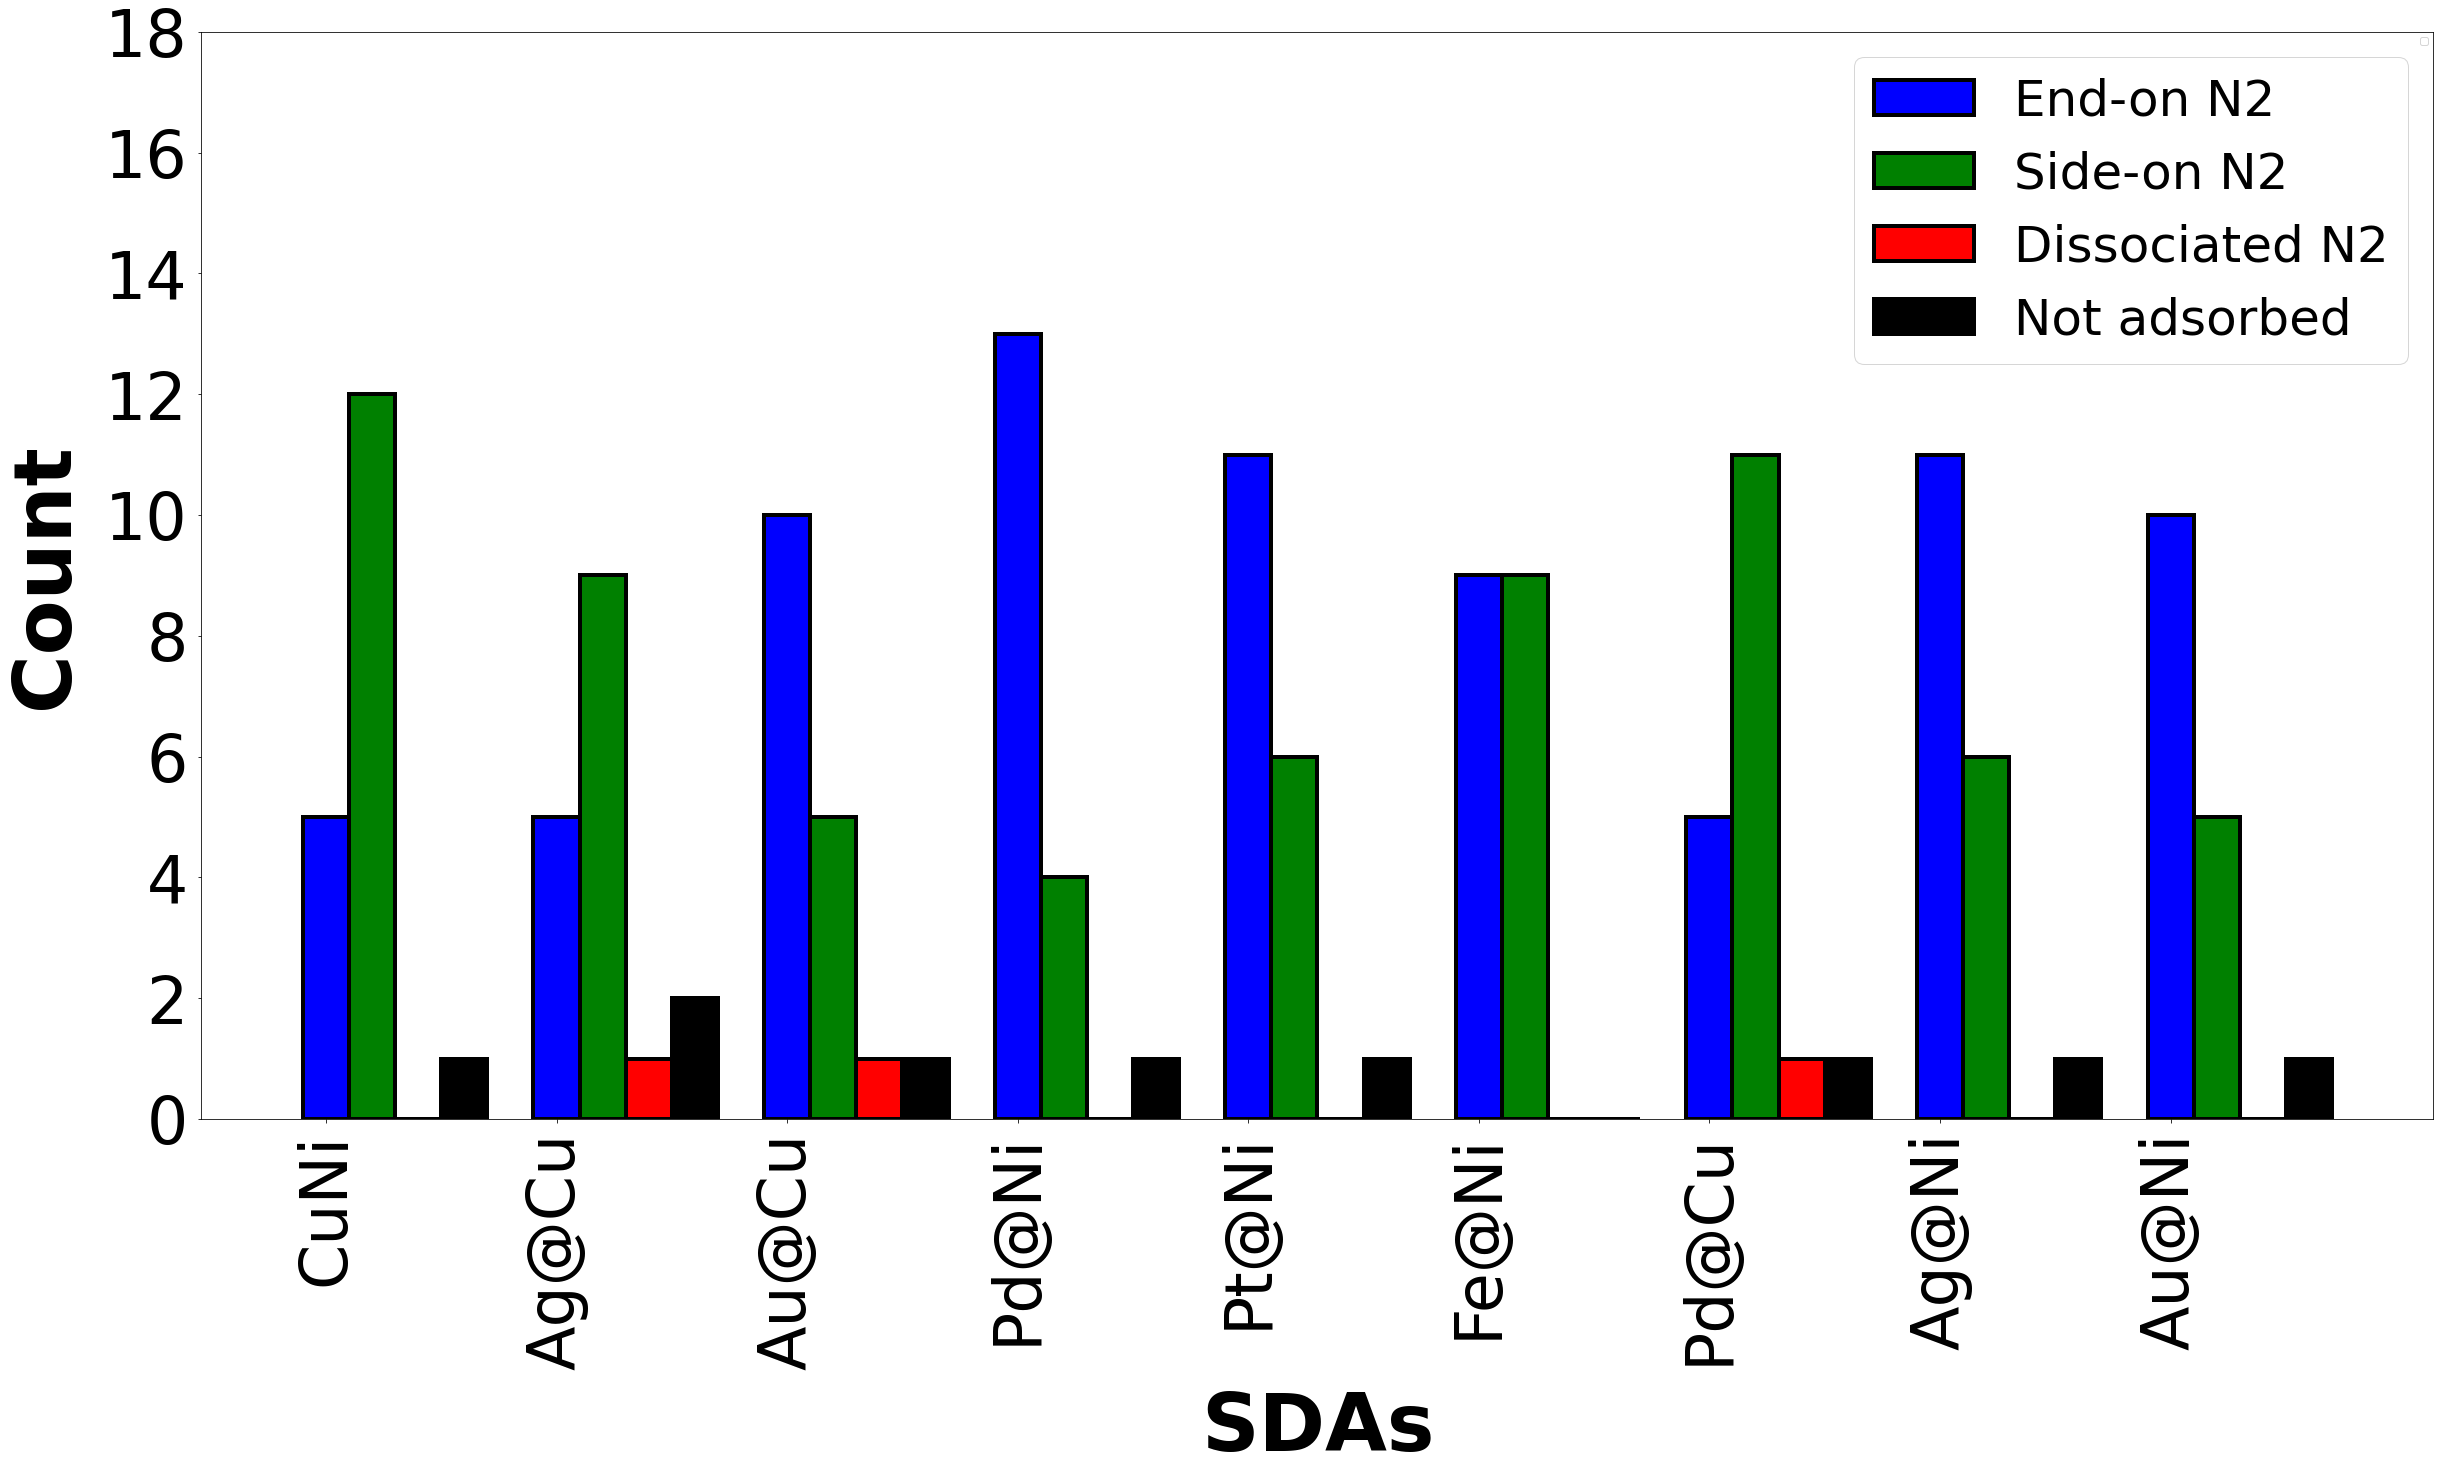

In [48]:
pylab.rcParams['xtick.major.pad']='10'
pylab.rcParams['ytick.major.pad']='10'

# Set the width of the bars
barWidth = 0.2
bar_group_dist = 0.2

# Set the position of the bars on the x-axis
x_labels = ['CuNi',
     'Ag@Cu',
     'Au@Cu',
     'Pd@Ni',
     'Pt@Ni',
     'Fe@Ni',
     'Pd@Cu',
     'Ag@Ni',
     'Au@Ni']

names = ['End-on N2','Side-on N2','Dissociated N2','Not adsorbed']
r1 = np.arange(len(adsorption_char_df['system']))
r2 = [x + bar_group_dist for x in r1]
r3 = [x + bar_group_dist for x in r2]
r4 = [x + bar_group_dist for x in r3]


fig = plt.figure(figsize=(40,20))
plt.ylim(0, 18)
# Create the bar plots
plt_vert = plt.bar(r1, adsorption_char_df['n_vertical_mol'], color='blue', width=barWidth, edgecolor='black',linewidth=4)
plt_horiz = plt.bar(r2, adsorption_char_df['n_horiz_mol'], color='green', width=barWidth, edgecolor='black',linewidth=4)
plt_diss = plt.bar(r3, adsorption_char_df['n_dissociated'], color='red', width=barWidth, edgecolor='black',linewidth=4)
plt_not = plt.bar(r4, adsorption_char_df['n_not_adsorbed'], color='black', width=barWidth, edgecolor='black',linewidth=4)
legend_1 = plt.legend([plt_vert,plt_horiz, plt_diss,plt_not], names, prop = { "size": 50 }, loc ="upper right",scatterpoints=1)
plt.gca().add_artist(legend_1)

# Add x-axis and y-axis labels and a title
plt.xlabel('SDAs',fontsize=80, labelpad=20,weight='bold')
plt.ylabel('Count',fontsize=80, labelpad=20,weight='bold')
plt.xticks(ticks=r1, labels=x_labels,rotation = 90,fontsize=65)
plt.yticks(fontsize=65)
#plt.title('')

# Add legend
plt.legend()

# Show the chart
#plt.savefig('./count_ads_mode.pdf',bbox_inches='tight',dpi=500)
plt.show()

No handles with labels found to put in legend.


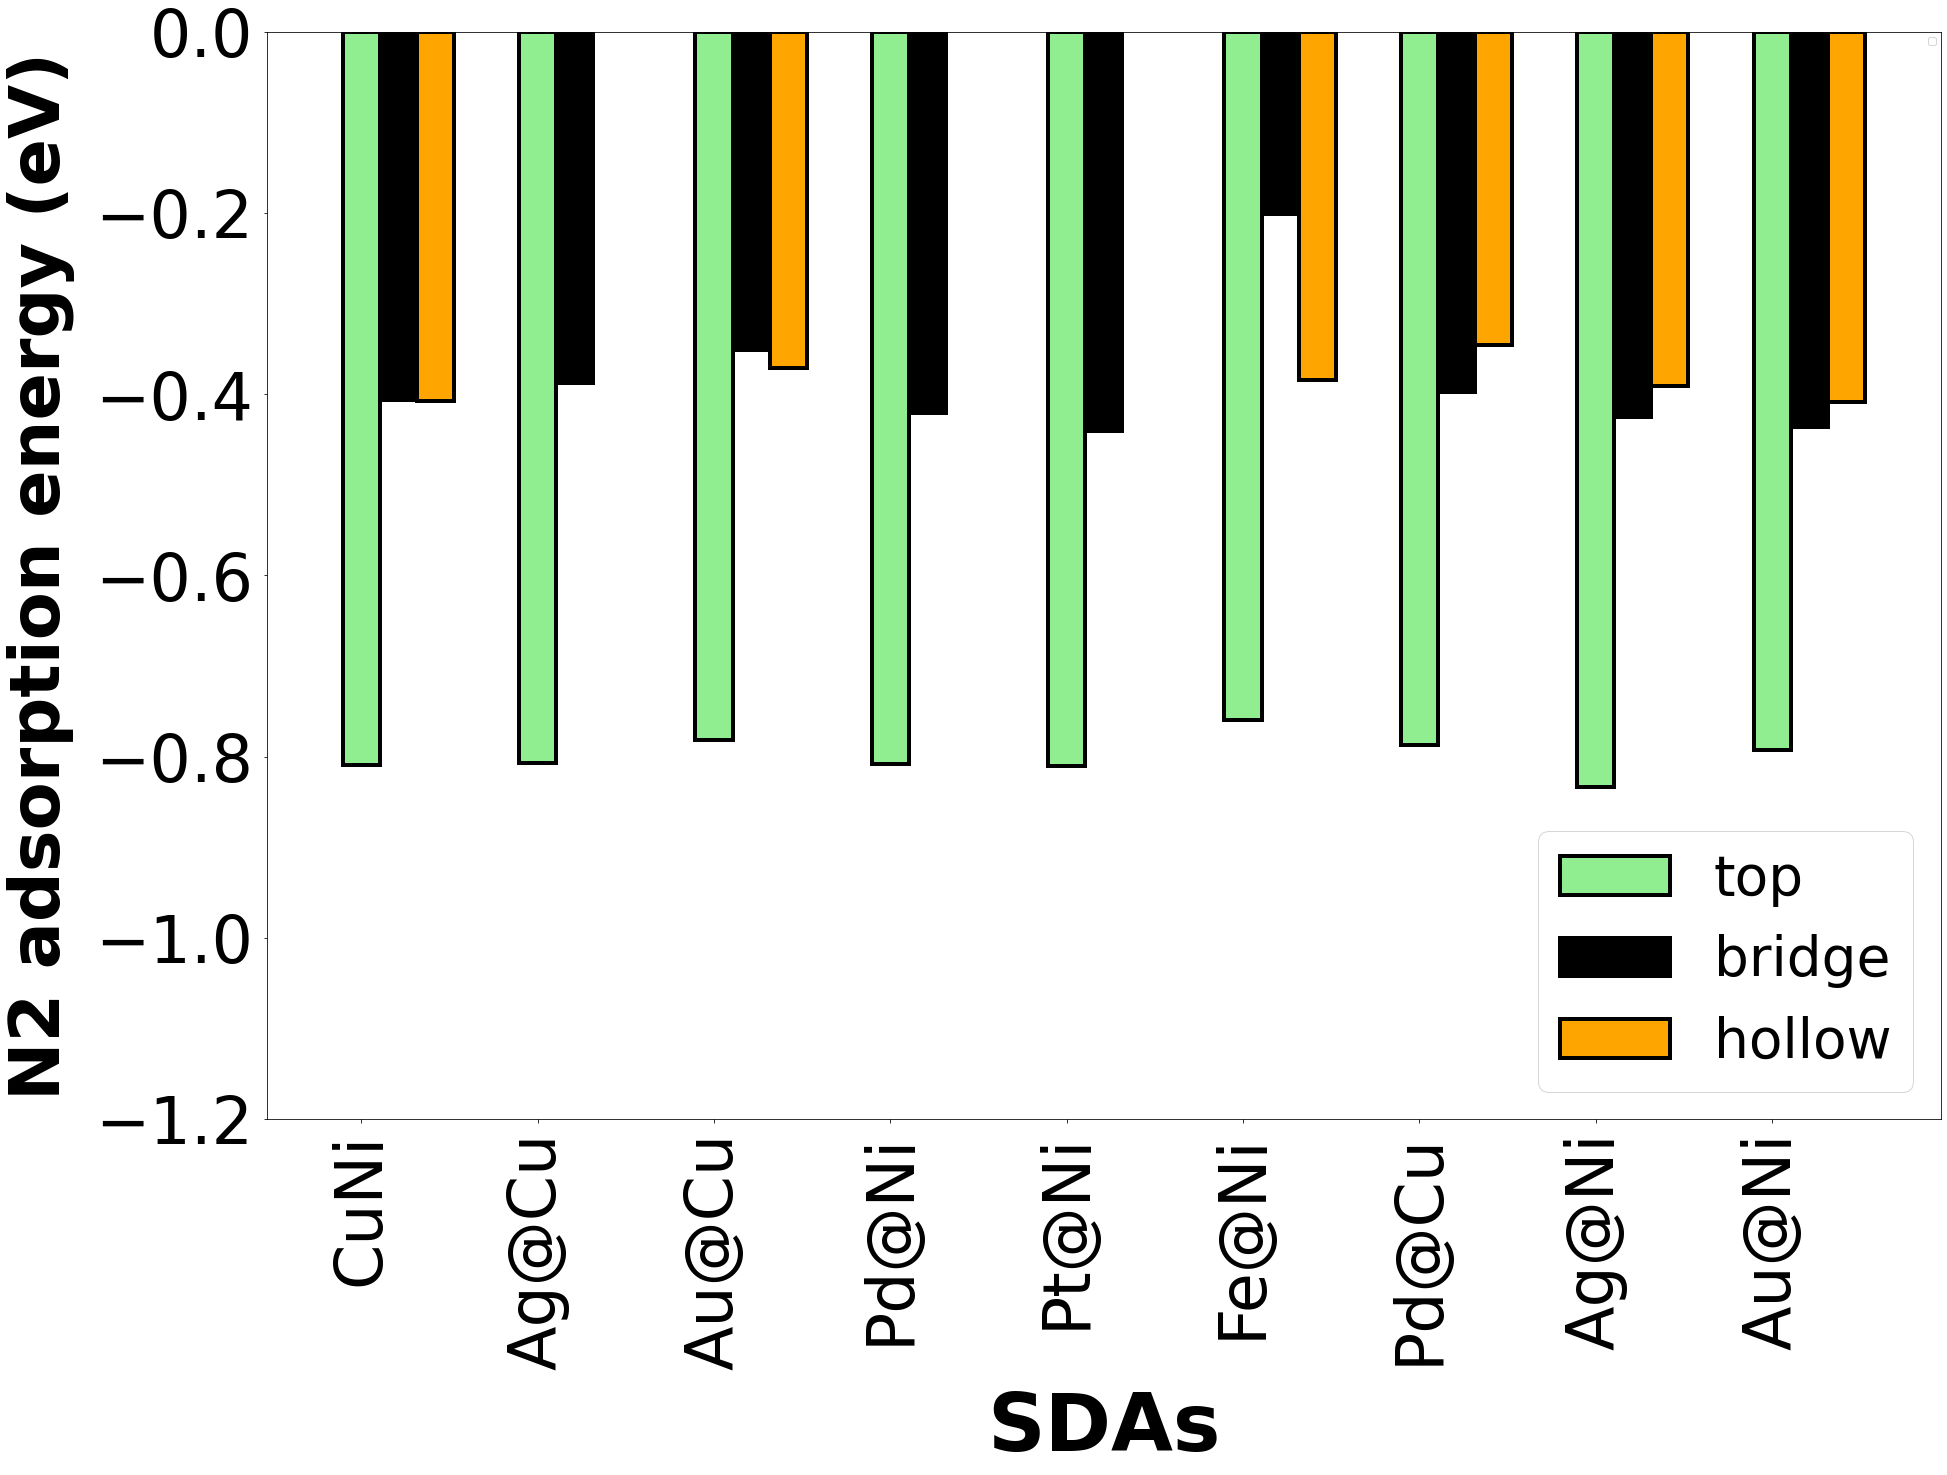

In [49]:
pylab.rcParams['xtick.major.pad']='10'
pylab.rcParams['ytick.major.pad']='10'

# Set the width of the bars
barWidth = 0.21
bar_group_dist = 0.21

df = comp_en_len_df

# Set the position of the bars on the x-axis
x_labels = ['CuNi',
     'Ag@Cu',
     'Au@Cu',
     'Pd@Ni',
     'Pt@Ni',
     'Fe@Ni',
     'Pd@Cu',
     'Ag@Ni',
     'Au@Ni']

names = ['top','bridge','hollow']
r1 = np.arange(len(adsorption_char_df['system']))
r2 = [x + bar_group_dist for x in r1]
r3 = [x + bar_group_dist for x in r2]


fig = plt.figure(figsize=(30,20))
plt.ylim(-1.2, 0)
# Create the bar plots
plt_1 = plt.bar(r1, df['top_adsE'], color='lightgreen', width=barWidth, edgecolor='black',linewidth=4)
plt_2 = plt.bar(r2, df['br_adsE'], color='black', width=barWidth, edgecolor='black',linewidth=4)
plt_3 = plt.bar(r3, df['hollow_adsE'], color='orange', width=barWidth, edgecolor='black',linewidth=4)
legend_1 = plt.legend([plt_1,plt_2, plt_3], names, prop = { "size": 55 }, loc ="lower right",scatterpoints=1)
plt.gca().add_artist(legend_1)

# Add x-axis and y-axis labels and a title
plt.xlabel('SDAs',fontsize=80, labelpad=20,weight='bold')
plt.ylabel('N2 adsorption energy (eV)',fontsize=70, labelpad=20,weight='bold')
plt.xticks(ticks=r1, labels=x_labels,rotation = 90,fontsize=65)
plt.yticks(fontsize=65)
#plt.title('')

# Add legend
plt.legend()

# Show the chart
#plt.savefig('./ads_config_E.pdf',bbox_inches='tight',dpi=500)
plt.show()

No handles with labels found to put in legend.


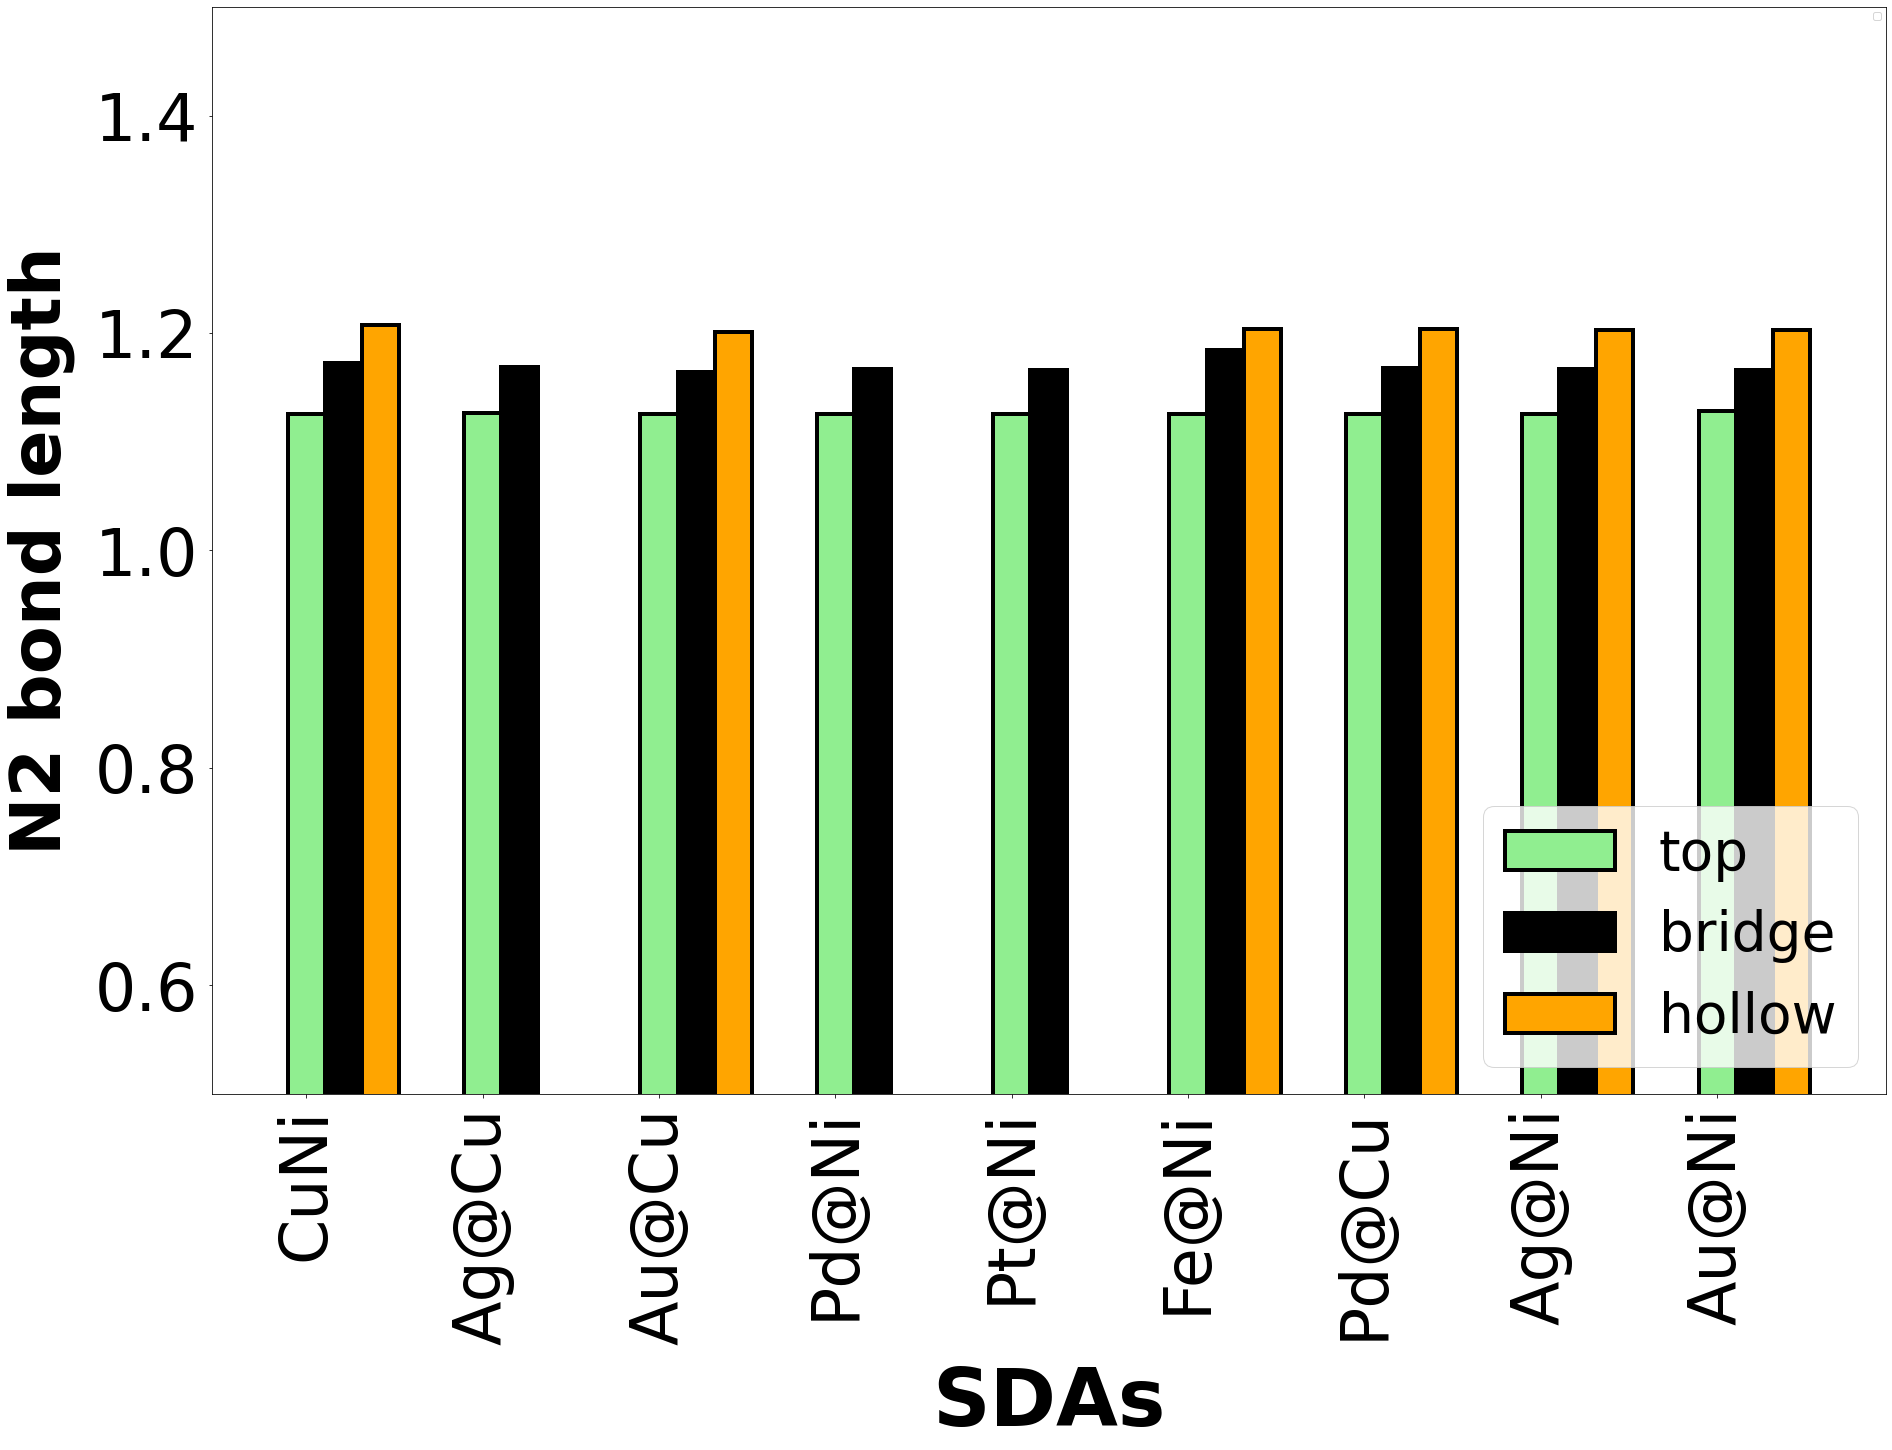

In [50]:
pylab.rcParams['xtick.major.pad']='10'
pylab.rcParams['ytick.major.pad']='10'

# Set the width of the bars
barWidth = 0.21
bar_group_dist = 0.21

df = comp_en_len_df

# Set the position of the bars on the x-axis
x_labels = ['CuNi',
     'Ag@Cu',
     'Au@Cu',
     'Pd@Ni',
     'Pt@Ni',
     'Fe@Ni',
     'Pd@Cu',
     'Ag@Ni',
     'Au@Ni']

names = ['top','bridge','hollow']
r1 = np.arange(len(adsorption_char_df['system']))
r2 = [x + bar_group_dist for x in r1]
r3 = [x + bar_group_dist for x in r2]


fig = plt.figure(figsize=(30,20))
plt.ylim(0.5, 1.5)
# Create the bar plots
plt_1 = plt.bar(r1, df['top_bond_length'], color='lightgreen', width=barWidth, edgecolor='black',linewidth=4)
plt_2 = plt.bar(r2, df['br_bond_length'], color='black', width=barWidth, edgecolor='black',linewidth=4)
plt_3 = plt.bar(r3, df['hollow_bond_length'], color='orange', width=barWidth, edgecolor='black',linewidth=4)
legend_1 = plt.legend([plt_1,plt_2, plt_3], names, prop = { "size": 55 }, loc ="lower right",scatterpoints=1)
plt.gca().add_artist(legend_1)

# Add x-axis and y-axis labels and a title
plt.xlabel('SDAs',fontsize=80, labelpad=20,weight='bold')
plt.ylabel('N2 bond length',fontsize=70, labelpad=20,weight='bold')
plt.xticks(ticks=r1, labels=x_labels,rotation = 90,fontsize=65)
plt.yticks(fontsize=65)
#plt.title('')

# Add legend
plt.legend()

# Show the chart
#plt.savefig('./bond_length_SDA.pdf',bbox_inches='tight',dpi=500)
plt.show()

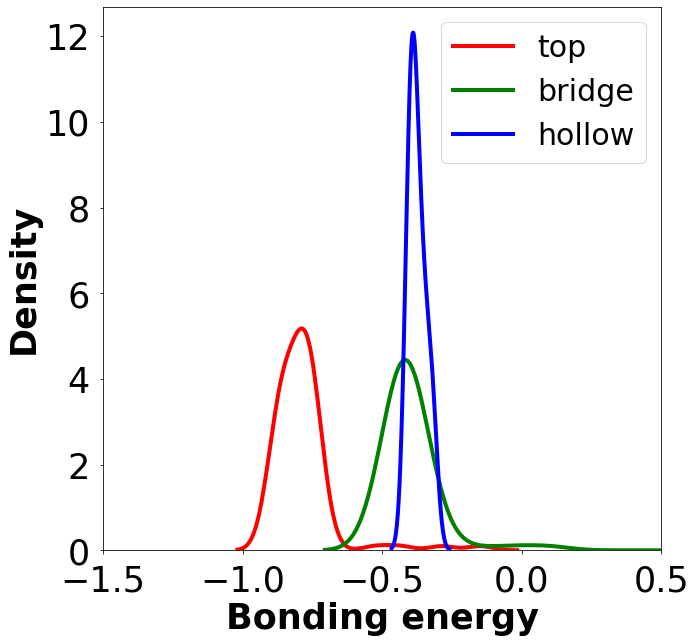

In [51]:
top_plt = merged_df[merged_df['ads_config'] == 'top']
br_plt = merged_df[merged_df['ads_config'] == 'br']
hollow_plt = merged_df[merged_df['ads_config'] == 'hollow']

all_dfs = [top_plt,
          br_plt,
          hollow_plt]

x_labels = ['top','bridge','hollow']
colors = ['red','green','blue']

fig, axes = plt.subplots(1,1,figsize = (10,10),sharey=False)
axes.set_xlim([-1.5, 0.5])
for i in range(len(all_dfs)):
    df_modified = all_dfs[i]
    name = x_labels[i]
    sns.kdeplot(df_modified['adsorption_energy (eV)-N2'],
                color=colors[i],linewidth=4,label=f'{x_labels[i]}')
axes.legend(loc='upper right', fontsize=30)
axes.set_xlabel("Bonding energy",fontsize=35,weight='bold')
axes.set_ylabel("Density",fontsize=35,weight='bold')
axes.tick_params(axis="x",labelsize=35)
axes.tick_params(axis="y",labelsize=35)
#plt.savefig('./adsE_dens.pdf',bbox_inches='tight',dpi=500)
plt.show()

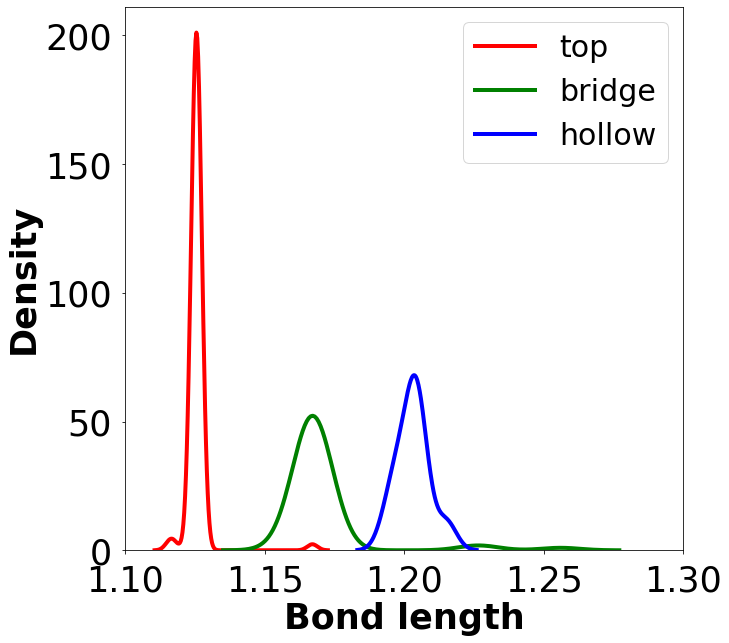

In [52]:
top_plt = merged_df[merged_df['ads_config'] == 'top']
br_plt = merged_df[merged_df['ads_config'] == 'br']
hollow_plt = merged_df[merged_df['ads_config'] == 'hollow']

all_dfs = [top_plt,
          br_plt,
          hollow_plt]

x_labels = ['top','bridge','hollow']
colors = ['red','green','blue']

fig, axes = plt.subplots(1,1,figsize = (10,10),sharey=False)
axes.set_xlim([round(1.1,1), 1.3])
for i in range(len(all_dfs)):
    df_modified = all_dfs[i]
    name = x_labels[i]
    sns.kdeplot(df_modified['NN_distance (ang)-N2'],
                color=colors[i],linewidth=4,label=f'{x_labels[i]}')
axes.legend(loc='upper right', fontsize=30)
axes.set_xlabel("Bond length",fontsize=35,weight='bold')
axes.set_ylabel("Density",fontsize=35,weight='bold')
axes.tick_params(axis="x",labelsize=35)
axes.tick_params(axis="y",labelsize=35)
#plt.savefig('./bondlength_dens.pdf',bbox_inches='tight',dpi=500)
plt.show()

In [53]:

print('top_bond_len:',merged_df[merged_df['ads_config']=='top']['NN_distance (ang)-N2'].median())
print('br_bond_len:',merged_df[merged_df['ads_config']=='br']['NN_distance (ang)-N2'].median())
print('hollow_bond_len:',merged_df[merged_df['ads_config']=='hollow']['NN_distance (ang)-N2'].median())

top_bond_len: 1.125
br_bond_len: 1.167
hollow_bond_len: 1.2035


In [54]:

print('top_adsE:',merged_df[merged_df['ads_config']=='top']['adsorption_energy (eV)-N2'].median())
print('br_adsE:',merged_df[merged_df['ads_config']=='br']['adsorption_energy (eV)-N2'].median())
print('hollow_adsE:',merged_df[merged_df['ads_config']=='hollow']['adsorption_energy (eV)-N2'].median())

top_adsE: -0.7959499999999999
br_adsE: -0.4099
hollow_adsE: -0.38655


In [55]:
merged_df.sort_values(by='NN_distance (ang)-N2',ascending=True)

,system,site_number,adsorption_energy (eV)-N2,NN_distance (ang)-N2,min mol_M distance-N2,max mol_M distance-N2,adsorbed (<2.0)-N2,dissociated (<1.35)-N2,mol_orient_vert(max_NM_dist > 2.1)-N2,ads_config
35,1_Ag_subCu,ad_site_17,-0.1311,1.109,3.2417,3.5865,0,0,NaN,NaN
22,1_Ag_subCu,ad_site_4,-0.1216,1.109,3.4648,4.3004,0,0,NaN,NaN
41,2_Au_subCu,ad_site_4,-0.1263,1.109,3.5863,4.4029,0,0,NaN,NaN
149,13_Ag_subNi,ad_site_17,-0.1437,1.110,3.2036,3.2119,0,0,NaN,NaN
73,6_Pd_subNi,ad_site_17,-0.1385,1.110,3.0209,3.3896,0,0,NaN,NaN
92,7_Pt_subNi,ad_site_17,-0.1427,1.110,3.0606,3.4998,0,0,NaN,NaN
168,14_Au_subNi,ad_site_17,-0.1457,1.110,3.1047,3.4551,0,0,NaN,NaN
3,0_CuNi,ad_site_4,-0.1498,1.116,3.3957,4.1974,0,0,NaN,top
117,11_Pd_subCu,ad_site_4,-0.2865,1.117,2.0597,3.1762,0,0,NaN,top
55,2_Au_subCu,ad_site_18,-0.7655,1.125,1.7969,2.9216,1,0,1.0,top


In [56]:
#SOEs = min_adsE_host - adsE_dopant
N2_E = -40.27971791


all_dfs = [Ag_Cu_df, 
           Au_Cu_df, 
           Pd_Ni_df, 
           Pt_Ni_df, 
           Fe_Ni_df, 
           Pd_Cu_df, 
           Ag_Ni_df, 
           Au_Ni_df]

surfEs =    [('1_Ag_subCu', -23797.8363377135),
             ('2_Au_subCu', -23617.2722294265),
             ('6_Pd_subNi', -23761.4546656967),
             ('7_Pt_subNi', -23773.5014076017),
             ('9_Fe_subNi', -23891.9643845808),
             ('11_Pd_subCu', -23700.9403383456),
             ('13_Ag_subNi', -23858.3546734375),
             ('14_Au_subNi', -23677.7874778272)]

df_names_dopantE =  [('Ag@Cu',-23838.0612895047),
                     ('Au@Cu',-23657.4920604255),
                     ('Pd@Ni',-23801.7436323879),
                     ('Pt@Ni',-23813.7983708471),
                     ('Fe@Ni',-23932.2825322685),
                     ('Pd@Cu',-23741.2411134851),
                     ('Ag@Ni',-23898.5769652461),
                     ('Au@Ni',-23718.0102131339)]

dopant_charges = [('Ag@Cu', -0.1198000000000014),
                  ('Au@Cu', -0.4458000000000002),
                  ('Pd@Ni', -0.3223999999999982),
                  ('Pt@Ni', -0.5869),
                  ('Fe@Ni', 0.3732000000000006),
                  ('Pd@Cu', -0.3326999999999991),
                  ('Ag@Ni', -0.1099999999999994),
                  ('Au@Ni', -0.4376999999999995)]
SOEs_list = []
for i in range(len(all_dfs)):
    df_ = all_dfs[i]
    name = df_names_dopantE[i][0]
    surf_E = surfEs[i][1]
    dopant_adsE = df_names_dopantE[i][1] - surf_E - N2_E
    host_adsE   = min(df_['adsorption_energy (eV)-N2'])
    SOE = host_adsE - dopant_adsE
    SOEs_list.append((name, SOE))
    
print(SOEs_list,'\n') #SOE kamtar hydrogenation assontar
print(dopant_charges)

[('Ag@Cu', -0.9249661187976729), ('Au@Cu', -0.9136869110019251), ('Pd@Ni', -0.8661512187985076), ('Pt@Ni', -0.8291546645994545), ('Fe@Ni', -0.8386702223001818), ('Pd@Cu', -0.8268427705020017), ('Ag@Ni', -0.9421261014027826), ('Au@Ni', -0.931982603300824)] 

[('Ag@Cu', -0.1198000000000014), ('Au@Cu', -0.4458000000000002), ('Pd@Ni', -0.3223999999999982), ('Pt@Ni', -0.5869), ('Fe@Ni', 0.3732000000000006), ('Pd@Cu', -0.3326999999999991), ('Ag@Ni', -0.1099999999999994), ('Au@Ni', -0.4376999999999995)]


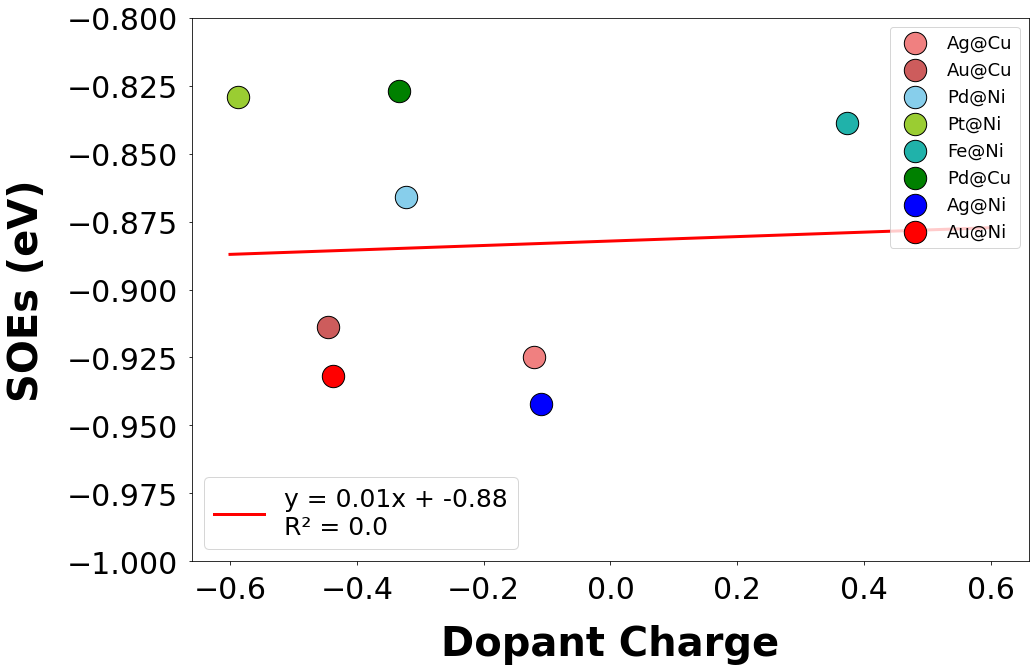

In [57]:
pylab.rcParams['xtick.major.pad']='10'
pylab.rcParams['ytick.major.pad']='10'


x_ = [i[1] for i in dopant_charges]
names_df = [i[0] for i in df_names_dopantE]
y_ = [i[1] for i in SOEs_list]
colors = ['lightcoral', #1
          'indianred',  #2
          'skyblue', #6
          'yellowgreen', #7
          'lightseagreen', #9
          'green', #11
          'blue',#13
          'red'] #14
#number = 13
#cmap = plt.get_cmap('gnuplot')
#colors = [cmap(i) for i in np.linspace(0, 1, number)]


#Find the best line fitting the electro and charge:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x_, y_)
r2 = r_value**2
x_line = [-0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
y_line = [(slope*i)+ intercept for i in x_line]
name = f'y = {round(slope,2)}x + {round(intercept,2)}' + '\n' + unicodeit.replace(f'R^2 = {round(r2,2)}')
#print(name)


markersize = 500
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
plt.ylim(-1, -0.8)

#for i in range(len(x_)):
plot_0 = plt.scatter(x_[0],y_[0], marker = 'o',s = markersize, color = colors[0], edgecolors='black') #_,color=colors,edgecolor='black',linewidth=4, width=0.6)
plot_1 =plt.scatter(x_[1],y_[1], marker = 'o',s = markersize, color = colors[1], edgecolors='black')
plot_2 =plt.scatter(x_[2],y_[2], marker = 'o',s = markersize, color = colors[2], edgecolors='black')
plot_3 =plt.scatter(x_[3],y_[3], marker = 'o',s = markersize, color = colors[3], edgecolors='black')
plot_4 =plt.scatter(x_[4],y_[4], marker = 'o',s = markersize, color = colors[4], edgecolors='black')
plot_5 =plt.scatter(x_[5],y_[5], marker = 'o',s = markersize, color = colors[5], edgecolors='black')
plot_6 =plt.scatter(x_[6],y_[6], marker = 'o',s = markersize, color = colors[6], edgecolors='black')
plot_7 =plt.scatter(x_[7],y_[7], marker = 'o',s = markersize, color = colors[7], edgecolors='black')
plt.axhline(0, color='black',linewidth=2)
fit_line = plt.plot(x_line,y_line,color='red',linewidth=3)
#plt.legend(names_df[i])
legend1 = plt.legend([plot_0, plot_1, plot_2,plot_3,
           plot_4, plot_5, plot_6,plot_7], names_df, prop = { "size": 18 }, loc ="upper right",scatterpoints=1)
plt.legend((fit_line), [(name)], prop = { "size": 25 }, loc ="lower left",scatterpoints=1)
plt.gca().add_artist(legend1)
plt.xticks(fontsize=30) #,rotation = +90)
plt.yticks(fontsize=30)
plt.ylabel('SOEs (eV)',fontsize=40, labelpad=20,weight='bold')
plt.xlabel('Dopant Charge',fontsize=40, labelpad=20,weight='bold')
#plt.legend(names_df[i])
plt.savefig('./SOEs_dopcharge_N2.pdf',bbox_inches='tight',dpi=500)
plt.show()
            